### Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import datetime
import matplotlib.dates

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Load input files

In [2]:
flights = pd.read_csv('../flights_small.csv')
weather = pd.read_csv('../weather.csv')

### Explore input files

+ Available columns in `flights` database   
   * `Date` Date of the flight
   * `Airline` Airline operating the flight
   * `Airline_code` (Same as Airline but with associated numerical code)
   * `Arrival_airport` Arrival airport
   * `Arrival_state` Arrival state
   * `Departure_Airport` Departure airport
   * `Departure_State` Departure state
   * `Departure_actual` Actual flight take off time
   * `Departure_delay` Delay at departure
   * `Arrival_actual` Actual flight landing time
   * `Arrival_delay` Delay at arrival
   * `Arrival_schedule` Scheduled departure time
   * `Departure_schedule` Scheduled arrival time
   * `DC_Longitude` Departure airport longitude
   * `DC_Latitude` Departure airport latitude
   * `Longitude` (Duplicate as DC_Longitude)
   * `Latitude` (Duplicate as DC_Latitude)
   * `Route` State to State route
   * `Path_order` (Array of 1s)
   
+ The database has 100000 entries

In [3]:
flights.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2003-04-05,EV,20366,SHV,LA,MOB,AL,1820,-10,2048,30,2018,1830,-88.24,30.69,-88.24,30.69,AL to LA,1
1,2006-04-10,YV,20378,CLT,NC,MGM,AL,1613,-10,1833,-9,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
2,2006-04-05,YV,20378,CLT,NC,MGM,AL,1615,-8,1825,-17,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
3,2006-01-12,YV,20378,CLT,NC,MGM,AL,1620,-3,1840,1,1839,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
4,2006-01-05,YV,20378,CLT,NC,MGM,AL,1614,0,1840,10,1830,1614,-86.39,32.30,-86.39,32.30,AL to NC,1


In [4]:
len(flights)

100000

In [5]:
flights.DC_Longitude.equals(flights.Longitude)

True

In [6]:
flights.DC_Latitude.equals(flights.Latitude)

True

In [7]:
flights.Path_order.unique()

array([1], dtype=int64)

+ Column type in `flights` database   
   * `Date`                   object
   * `Airline`                object
   * `Airline_code`            int64
   * `Arrival_airport`        object
   * `Arrival_state`          object
   * `Departure_Airport`      object
   * `Departure_State`        object
   * `Departure_actual`        int64
   * `Departure_delay`         int64
   * `Arrival_actual`          int64
   * `Arrival_delay`           int64
   * `Arrival_schedule`        int64
   * `Departure_schedule`      int64
   * `DC_Longitude`          float64
   * `DC_Latitude`           float64
   * `Longitude`             float64
   * `Latitude`              float64
   * `Route`                  object
   * `Path_order`              int64
   
   Date and time data need conversion from string to datetime format

In [8]:
flights.dtypes

Date                   object
Airline                object
Airline_code            int64
Arrival_airport        object
Arrival_state          object
Departure_Airport      object
Departure_State        object
Departure_actual        int64
Departure_delay         int64
Arrival_actual          int64
Arrival_delay           int64
Arrival_schedule        int64
Departure_schedule      int64
DC_Longitude          float64
DC_Latitude           float64
Longitude             float64
Latitude              float64
Route                  object
Path_order              int64
dtype: object

In [9]:
flights['Date'] = pd.to_datetime(flights['Date'])

flights['Departure_actual'] = flights.Departure_actual.map("{:04}".format).str.replace('2400', '0000')
flights['Departure_actual'] = pd.to_datetime(flights.Departure_actual, format='%H%M').dt.time

flights['Departure_schedule'] = flights.Departure_schedule.map("{:04}".format).str.replace('2400', '0000')
flights['Departure_schedule'] = pd.to_datetime(flights.Departure_schedule, format='%H%M').dt.time

flights['Arrival_actual'] = flights.Arrival_actual.map("{:04}".format).str.replace('2400', '0000')
flights['Arrival_actual'] = pd.to_datetime(flights.Arrival_actual, format='%H%M').dt.time

flights['Arrival_schedule'] = flights.Arrival_schedule.map("{:04}".format).str.replace('2400', '0000')
flights['Arrival_schedule'] = pd.to_datetime(flights.Arrival_schedule, format='%H%M').dt.time

+ Temporal information:   
   * `Date`s range from 2002-01-01 to 2012-12-31
   * the dataset contains information on 9091 +- 1183 flights per year    

In [10]:
print(flights['Date'].min(), flights['Date'].max())

2002-01-01 00:00:00 2012-12-31 00:00:00


In [11]:
flights['Year'] = flights['Date'].dt.year
flights['Month'] = flights['Date'].dt.month
flights['Day'] = flights['Date'].dt.day
year_count = flights.Year.value_counts()
print('Flights per year: {:.0f} +- {:.0f}'.format(np.mean(year_count), np.std(year_count)))

Flights per year: 9091 +- 1183


+ Route information:
   * data for 23 different `Airline`s is available
   * the number of flights available for each airline varies greatly   
   (e.g. information on 20728 flights is available for US (US Airways), on 29 flights for VX (Virgin America))   
   *care should therefore be taken when interpreting the results by airline*
   * data for 99 different `Departure_airport`s is available (as per the airlines, the number of available data varies)
   * data for 19 different `Arrival_airport`s is available (as per the airlines, the number of available data varies)
   * not all `Arrival_airport`s are also `Departure_airport`s

In [12]:
len(flights.Airline.value_counts())

23

In [13]:
flights.Airline.value_counts()

US    20728
DL    12012
WN    10391
UA     7763
OO     6100
MQ     5738
OH     5291
FL     4144
EV     3979
YV     3762
XE     3292
AS     3037
AA     2846
CO     2846
F9     1900
B6     1703
HP     1703
DH     1079
9E      700
NW      696
HA      151
TZ      110
VX       29
Name: Airline, dtype: int64

In [14]:
len(flights.Departure_Airport.value_counts())

99

In [15]:
flights.Departure_Airport.value_counts()

ATL    9890
DFW    6728
IAH    5485
BWI    3947
ORD    3516
ABQ    3511
LAS    3451
EWR    3376
LAX    2712
PIT    2638
PHX    2617
SEA    2501
DCA    2403
SLC    2361
MCO    2311
STL    2177
IND    2156
BNA    1782
TPA    1748
OAK    1711
SFO    1680
RIC    1598
MCI    1528
PDX    1391
CLT    1317
IAD    1236
RDU    1134
SDF    1127
BOI    1045
BIL     835
       ... 
OGG     170
TUS     165
AVL     160
SNA     150
PNS     149
PVD     130
PSP     129
GSO     124
OTH      98
ISP      94
HNL      85
LAW      53
FLL      37
PBI      27
CAE      20
MKE      15
TUL      15
IDA      15
HOU      12
JAX      11
LNK      10
MGM       8
EGE       6
COS       3
ACK       3
BDL       2
XNA       1
PHF       1
MOB       1
MLU       1
Name: Departure_Airport, Length: 99, dtype: int64

In [16]:
len(flights.Arrival_airport.value_counts())

19

In [17]:
flights.Arrival_airport.value_counts()

CLT    17395
DEN    15080
CVG    10009
PHX     9127
BOS     8082
PDX     6930
PHL     6850
PNS     6137
SAV     4552
SHV     3985
ATL     3417
SFO     2244
SAN     2111
DAB     1654
TUL      899
SJT      892
PIT      544
COU       52
CYS       40
Name: Arrival_airport, dtype: int64

* Delay information:   
   + About 35% of flights are delayed at departure (`Departure_delay`)
   + About 41% of flights are delayed at arrival (`Arrival_delay`)
   + About 27% of flights are delayed both at departure and arrival   
   
   *NB. Delay is defined as the flight taking off/landing after the scheduled time, even for just 1 minute*

In [18]:
len(flights.loc[flights.Departure_delay > 0])

35273

In [19]:
len(flights.loc[flights.Arrival_delay > 0])

41195

In [20]:
len(flights.loc[(flights.Departure_delay > 0) & (flights.Arrival_delay > 0)])

26658

+ Available columns in `weather` database   
   * `Date` Date of the measurement
   * `airport` Airport where the measurement was taken
   * `time` Time of the measurement
   * `temperature` Measured temperature in degree F
   * `snow` Measured snowfall in inches (?)
   * `wind` Measured wind in mph (?)
   
+ The database has 35488695 entries
+ Information for 273 airports is available

In [21]:
weather.head()

,Date,airport,time,temperature,snow,wind
0,2006-03-14,ORD,2041,35,NaN,18.6
1,2006-09-08,SLC,807,72,NaN,6.5
2,2006-10-22,MCO,1202,81,0.0,3.1
3,2006-10-22,MCO,602,81,0.0,3.1
4,2007-07-09,MRY,1011,64,NaN,0.7


In [22]:
len(weather)

35488695

In [23]:
# convert to datetime formats
weather['Date'] = pd.to_datetime(weather['Date'])
weather['time'] = weather.time.map("{:04}".format).str.replace('2400', '0000')
weather['time'] = pd.to_datetime(weather.time, format='%H%M').dt.time

In [24]:
len(weather.airport.unique())

273

+ Temporal information for weather:   
   * `Date`s range from 2005-01-01 to 2007-07-18 (929 days: data is available for every date)
   * for a given `Date` and `airport` the weather data look the same for each `time` entry  

In [25]:
print(weather['Date'].min(), weather['Date'].max())

2005-01-01 00:00:00 2007-07-18 00:00:00


In [26]:
len(weather.Date.value_counts())

929

In [27]:
weather.loc[(weather.Date == '2005-01-01 00:00:00') & (weather.airport == 'BOS')]

,Date,airport,time,temperature,snow,wind
260,2005-01-01,BOS,10:24:00,43,NaN,10.9
263,2005-01-01,BOS,08:26:00,43,NaN,10.9
80278,2005-01-01,BOS,18:50:00,43,NaN,10.9
88038,2005-01-01,BOS,10:28:00,43,NaN,10.9
177166,2005-01-01,BOS,13:19:00,43,NaN,10.9
179367,2005-01-01,BOS,06:00:00,43,NaN,10.9
179368,2005-01-01,BOS,11:06:00,43,NaN,10.9
182834,2005-01-01,BOS,15:01:00,43,NaN,10.9
182835,2005-01-01,BOS,07:04:00,43,NaN,10.9
222913,2005-01-01,BOS,06:05:00,43,NaN,10.9


### Data cleaning and visualisation
#### Routes
To visualise commercial flights routes we need:
* information on airport geographical coordinates
* information on where each route starts and ends

##### Airport coordinates

In [28]:
# list of airports for departures and arrival
flights_DA = flights['Departure_Airport'].unique()
flights_AA = flights['Arrival_airport'].unique()

# list of all airports
flights_A = np.unique(np.concatenate((flights_DA,flights_AA),0))

# put list in dataframe
idx = np.arange(len(flights_A))
airports = pd.Series(data=flights_A, index=idx).to_frame()
airports.columns = ['Airport']

In [29]:
# retrieve coordinates for departure flights from the `flights` database
departure_airport_coord = flights[['Departure_Airport','Longitude','Latitude']].drop_duplicates().reset_index()
departure_airport_coord = departure_airport_coord[['Departure_Airport', 'Longitude','Latitude']]
departure_airport_coord.columns = ['Airport','Longitude','Latitude']

In [30]:
# add missing information for arrival only airports
airport_coord = pd.merge(airports, departure_airport_coord, on = 'Airport', how = 'left')

long_dict = {'COU':-92.22,'CYS':-104.82,'DAB':-81.05,'SHV':-93.82, 'SJT':-100.29}
lat_dict = {'COU':38.82,'CYS':41.15,'DAB':29.17,'SHV':32.44, 'SJT':31.21}

airport_coord.Longitude = airport_coord.Longitude.fillna(airport_coord.Airport.map(long_dict))
airport_coord.Latitude = airport_coord.Latitude.fillna(airport_coord.Airport.map(lat_dict))

In [31]:
airport_coord.head()

,Airport,Longitude,Latitude
0,ABE,-75.44,40.65
1,ABQ,-106.60,35.04
2,ACK,-70.06,41.25
3,ALB,-73.80,42.74
4,ATL,-84.42,33.63


##### Route information

In [32]:
# retrieve departure/arrival airports from the `flights` database for each route
route = flights[['Departure_Airport','Arrival_airport']].drop_duplicates().reset_index()
route = route[['Departure_Airport', 'Arrival_airport']]

In [33]:
# add information on the departure/arrival coordinates
route_coord = pd.merge(route, airport_coord, left_on='Departure_Airport', right_on = 'Airport', how = 'left')
route_coord = pd.merge(route_coord, airport_coord, left_on='Arrival_airport', right_on = 'Airport', how = 'left')
route_coord = route_coord[route_coord.columns[2:]]
route_coord.head()

,Airport_x,Longitude_x,Latitude_x,Airport_y,Longitude_y,Latitude_y
0,MOB,-88.24,30.69,SHV,-93.82,32.44
1,MGM,-86.39,32.30,CLT,-80.94,35.21
2,XNA,-94.30,36.28,SHV,-93.82,32.44
3,TUS,-110.94,32.11,SFO,-122.37,37.61
4,PHX,-112.01,33.43,DEN,-104.67,39.86


##### Visualise routes

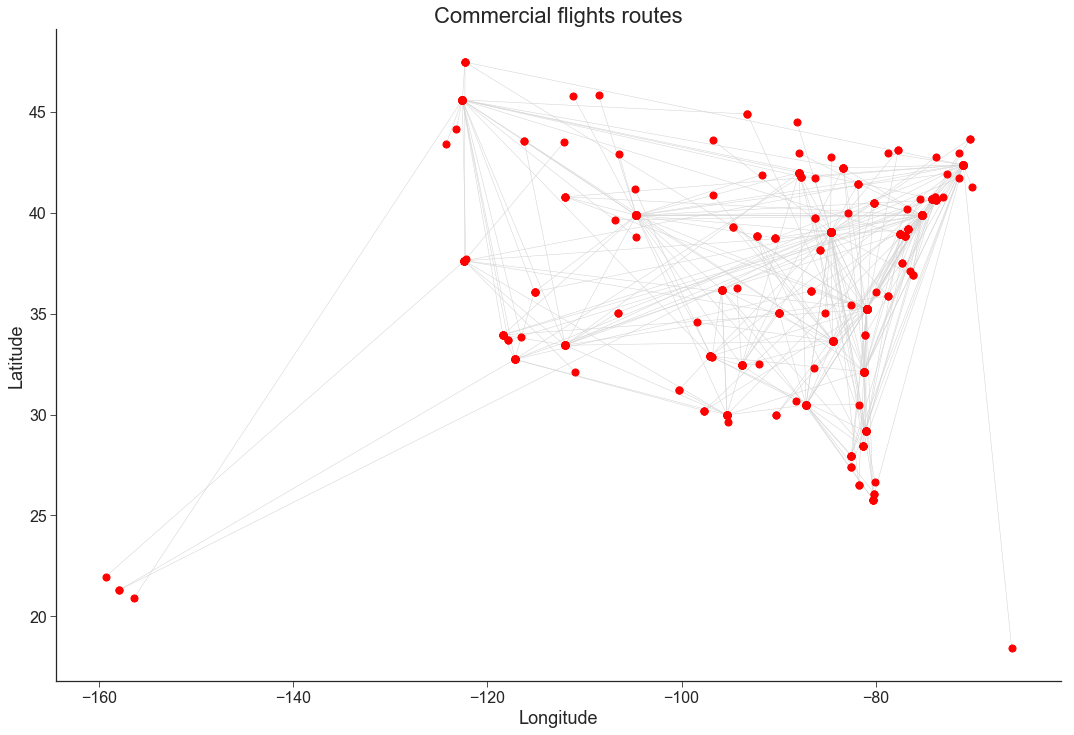

In [34]:
fig = plt.figure(figsize=(18,12))
ax = plt.gca

# sns.set_context('talk')
sns.set_style('ticks')

plt.plot([route_coord.Longitude_x, route_coord.Longitude_y],[route_coord.Latitude_x, route_coord.Latitude_y], color = 'lightgray', linewidth = 0.5);
plt.scatter(route_coord.Longitude_x, route_coord.Latitude_x, color = 'r', s = 50, zorder = 10);
plt.scatter(route_coord.Longitude_y, route_coord.Latitude_y, color = 'r', s = 50, zorder = 10);

plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('Commercial flights routes', fontsize = 22)

plt.tick_params(labelsize=16)

sns.despine()

##### Visualise route: example for US Airways operated flights

In [35]:
# retrieve route information for US Airways
routeUS = flights[['Departure_Airport','Arrival_airport', 'Airline']].drop_duplicates().reset_index()
routeUS = routeUS[['Departure_Airport', 'Arrival_airport', 'Airline']].loc[routeUS.Airline == 'US']

# add information on the departure/arrival coordinates
routeUS_coord = pd.merge(routeUS, airport_coord, left_on='Departure_Airport', right_on = 'Airport', how = 'left')
routeUS_coord = pd.merge(routeUS_coord, airport_coord, left_on='Arrival_airport', right_on = 'Airport', how = 'left')
routeUS_coord = routeUS_coord[routeUS_coord.columns[2:]]

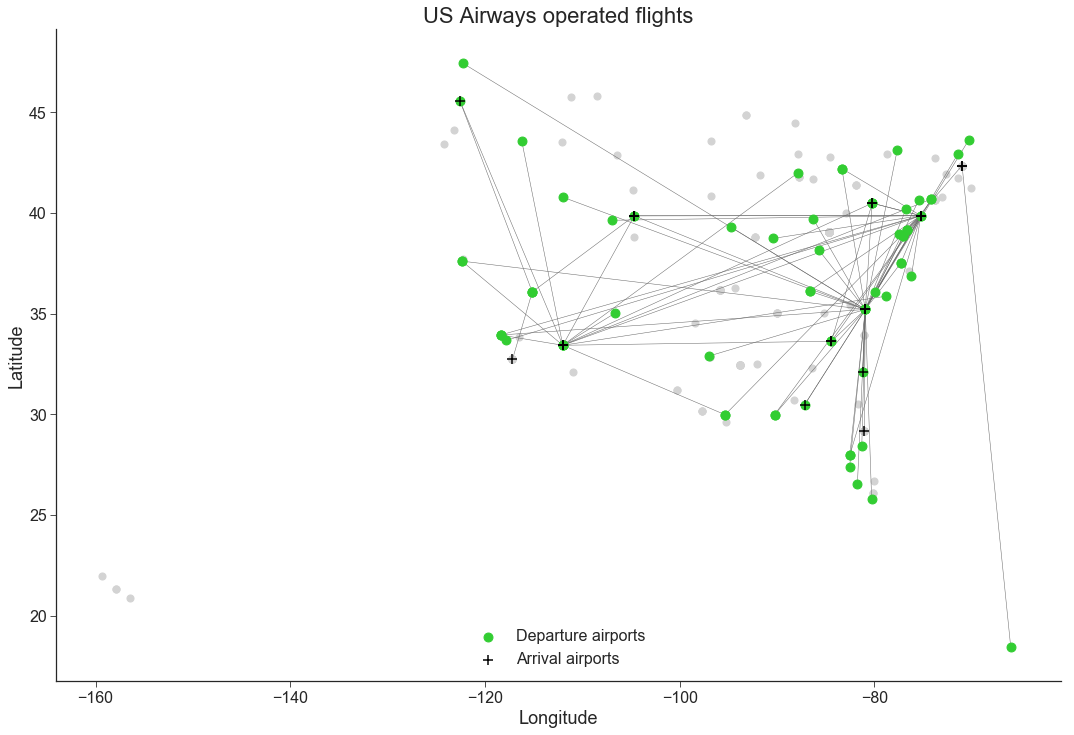

In [36]:
fig = plt.figure(figsize=(18,12))
ax = plt.gca()

sns.set_style('ticks')

plt.scatter(route_coord.Longitude_x, route_coord.Latitude_x, color = 'lightgray', s = 50, label = None);
plt.scatter(route_coord.Longitude_y, route_coord.Latitude_y, color = 'lightgray', s = 50, label = None);

plt.plot([routeUS_coord.Longitude_x, routeUS_coord.Longitude_y],[routeUS_coord.Latitude_x, routeUS_coord.Latitude_y], color = 'dimgray', linewidth = 0.5);
plt.scatter(routeUS_coord.Longitude_x, routeUS_coord.Latitude_x, marker = 'o', color = 'limegreen', s = 80, label = 'Departure airports', zorder = 10);
plt.scatter(routeUS_coord.Longitude_y, routeUS_coord.Latitude_y, marker = '+', color = 'k', s = 120, label = 'Arrival airports', zorder = 20);

plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('US Airways operated flights', fontsize = 22)

plt.tick_params(labelsize=16)

plt.legend(fontsize=16, loc = 8)

sns.despine()

#### Weather
The data for the weahter span a shorter time frame than the flights.   
To account for this, daily averages of weather phenomena for each airport can be used.

To visualise weather phenomena trends we need:
* daily averages for each airport

##### Daily averages

In [37]:
# rename `weather` columns
weather.columns = ['Date','Airport','Time','Temperature','Snow','Wind']

# list of all airports for which weather information is available in `weather`
weather_A = weather['Airport'].unique()

# delete information for airports not present in `flights` 
# remove the `time` feature as all the entries for each day are the same
weather_flights = weather[['Date','Airport','Temperature','Snow','Wind']].drop_duplicates().loc[weather['Airport'].isin(airports['Airport'])]

# fill NaN in the `Snow` columns by hypothesising that if the measure was not available it was not snowing 
weather_flights.Snow = weather_flights.Snow.fillna(0.0)

###### 1. Snow

In [38]:
# Create df with daily averages for each airport
snow = pd.pivot_table(weather_flights, values=['Snow'], index=['Date'],columns=['Airport'])
snow = snow.groupby([snow.index.month,snow.index.day]).mean()
snow.index.names = ['Month', 'Day']

In [39]:
# check which columns contains NaN 
col_nan = snow.columns[snow.isna().any()].tolist()
print('The following columns contain NaN: {}'.format(col_nan))

The following columns contain NaN: [('Snow', 'ACK'), ('Snow', 'CYS')]


In [40]:
# how many daily averages are missing over 365 days for the ACK and CYS airports?
print('ACK airport has {}/365 snow daily average values missing'.format(snow.Snow.ACK.isna().sum()))
print('CYS airport has {}/365 snow daily average values missing'.format(snow.Snow.CYS.isna().sum()))

ACK airport has 261/365 snow daily average values missing
CYS airport has 364/365 snow daily average values missing


In [41]:
# find snow information to closest airport to ACK and CYS
lat_ACK = airport_coord.Latitude.loc[airport_coord.Airport == 'ACK'].item()
lon_ACK = airport_coord.Longitude.loc[airport_coord.Airport == 'ACK'].item()

lat_CYS = airport_coord.Latitude.loc[airport_coord.Airport == 'CYS'].item()
lon_CYS = airport_coord.Longitude.loc[airport_coord.Airport == 'CYS'].item()

# find closest airport
def dist(lat1, lon1, lat2, lon2):
    return np.abs((lat1-lat2)+(lon1-lon2))

def find_closest_airport(lat, lon):
    distances = airport_coord.apply(
        lambda row: dist(lat, lon, row['Latitude'], row['Longitude']), 
        axis=1)
    return  airport_coord.loc[distances.nsmallest(n=2).index[1], 'Airport']

print('The closest airport to ACK is {}'.format(find_closest_airport(lat_ACK, lon_ACK)))
print('The closest airport to CYS is {}'.format(find_closest_airport(lat_CYS, lon_CYS)))

The closest airport to ACK is BOS
The closest airport to CYS is CPR


In [42]:
# fill NaN with values for closer airports (hypothesising similar weather for close geographical locations)
snow.Snow.ACK = snow.Snow.ACK.fillna(snow.Snow.BOS)
snow.Snow.CYS = snow.Snow.CYS.fillna(snow.Snow.CPR)

Visualise snow fall daily averages for two US locations and for the whole USA

In [43]:
# BIL: Billings Logan Intl Airport (Montana)
snow_montana = snow.Snow.BIL.to_frame()
# DEN: Denver Intl Airport (Colorado)
snow_colorado = snow.Snow.DEN.to_frame()

In [44]:
# average snow in the US
snow_US = snow.mean(axis=1).to_frame()
snow_US.columns = ['Average']

In [45]:
# retrieve date information for plotting
snow_colorado['Date'] = [str(snow_colorado.index[i][0])+'-'+str(snow_colorado.index[i][1]) for i in range(len(snow_colorado))]
snow_colorado['Date'] = pd.to_datetime(snow_colorado.Date, format='%m-%d') #.dt.strftime('%m-%d')

snow_montana['Date'] = [str(snow_montana.index[i][0])+'-'+str(snow_montana.index[i][1]) for i in range(len(snow_montana))]
snow_montana['Date'] = pd.to_datetime(snow_montana.Date, format='%m-%d') #.dt.strftime('%m-%d')

snow_US['Date'] = [str(snow_US.index[i][0])+'-'+str(snow_US.index[i][1]) for i in range(len(snow_US))]
snow_US['Date'] = pd.to_datetime(snow_US.Date, format='%m-%d') #.dt.strftime('%m-%d')

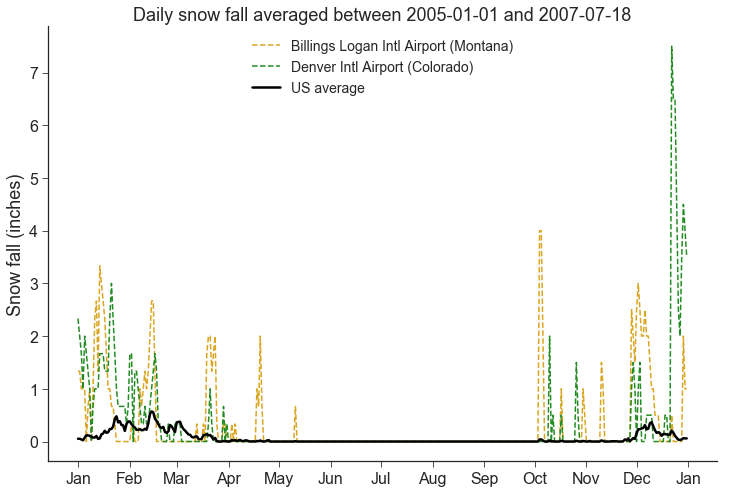

In [46]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

sns.set_style('ticks')

plt.plot(snow_montana.Date, snow_montana.BIL, '--', label = 'Billings Logan Intl Airport (Montana)', color = 'goldenrod');
plt.plot(snow_colorado.Date, snow_colorado.DEN, '--', label = 'Denver Intl Airport (Colorado)', color = 'forestgreen');
plt.plot(snow_US.Date, snow_US.Average, 'k-', label = 'US average', linewidth = 2.5);

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))

plt.ylabel('Snow fall (inches)',fontsize=18)
plt.tick_params(labelsize=16)

plt.legend(fontsize=14, loc=9)
plt.title('Daily snow fall averaged between 2005-01-01 and 2007-07-18', fontsize = 18)

sns.despine()

* Both Denver Intl Airport (Colorado) and Billings Logan Intl Airport (Montana) have higher snow falls than the US average in the colder months
* Billings Logan Intl Airport sees more snow during spring, while Denver Intl Airport has higher peaks towards the end of December

###### 2. Temperature

In [47]:
# Create df with daily averages for each airport
temperature = pd.pivot_table(weather_flights, values=['Temperature'], index=['Date'],columns=['Airport'])
temperature = temperature.groupby([temperature.index.month,temperature.index.day]).mean()
temperature.index.names = ['Month', 'Day']

In [48]:
# check which columns contains NaN 
col_nan_temp = temperature.columns[temperature.isna().any()].tolist()
print('The following columns contain NaN: {}'.format(col_nan_temp))

The following columns contain NaN: [('Temperature', 'ACK'), ('Temperature', 'CYS')]


In [49]:
# how many daily averages are missing over 365 days for the ACK and CYS airports?
print('ACK airport has {}/365 temperature daily average values missing'.format(temperature.Temperature.ACK.isna().sum()))
print('CYS airport has {}/365 temperature daily average values missing'.format(temperature.Temperature.CYS.isna().sum()))

ACK airport has 261/365 temperature daily average values missing
CYS airport has 364/365 temperature daily average values missing


In [50]:
# fill NaN with values for closer airports (hypothesising similar weather for close geographical locations)
# N.B. the missing values are similar to the snow fall data
temperature.Temperature.ACK = temperature.Temperature.ACK.fillna(temperature.Temperature.BOS)
temperature.Temperature.CYS = temperature.Temperature.CYS.fillna(temperature.Temperature.CPR)

Visualise temperature daily averages for two US locations and for the whole USA

In [51]:
# MIA: Miami Intl Airport (Florida)
temperature_miami = temperature.Temperature.MIA.to_frame()
# JFK: John F. Kennedy International Airport (New York)
temperature_NY = temperature.Temperature.JFK.to_frame()

# average temperature in the US
temperature_US = temperature.mean(axis=1).to_frame()
temperature_US.columns = ['Average']

In [52]:
# retrieve date information for plotting
temperature_miami['Date'] = [str(temperature_miami.index[i][0])+'-'+str(temperature_miami.index[i][1]) for i in range(len(temperature_miami))]
temperature_miami['Date'] = pd.to_datetime(temperature_miami.Date, format='%m-%d') #.dt.strftime('%m-%d')

temperature_NY['Date'] = [str(temperature_NY.index[i][0])+'-'+str(temperature_NY.index[i][1]) for i in range(len(temperature_NY))]
temperature_NY['Date'] = pd.to_datetime(temperature_NY.Date, format='%m-%d') #.dt.strftime('%m-%d')

temperature_US['Date'] = [str(temperature_US.index[i][0])+'-'+str(temperature_US.index[i][1]) for i in range(len(temperature_US))]
temperature_US['Date'] = pd.to_datetime(temperature_US.Date, format='%m-%d') #.dt.strftime('%m-%d')

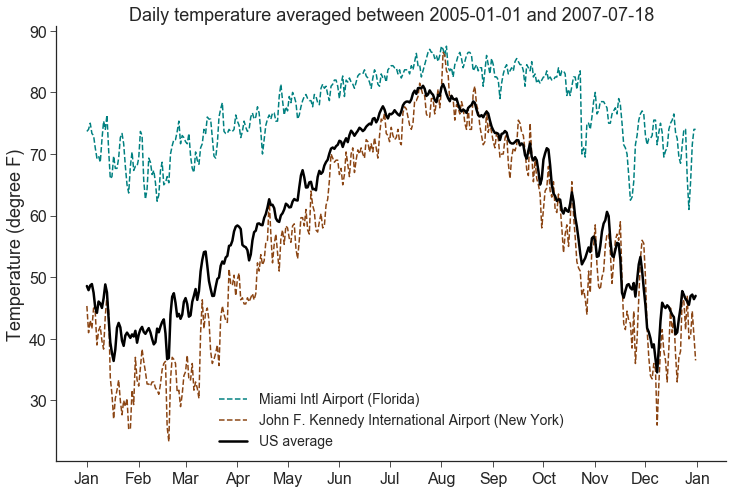

In [53]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

sns.set_style('ticks')

plt.plot(temperature_miami.Date, temperature_miami.MIA, '--', label = 'Miami Intl Airport (Florida)', color = 'teal');
plt.plot(temperature_NY.Date, temperature_NY.JFK, '--', label = 'John F. Kennedy International Airport (New York)', color = 'saddlebrown');
plt.plot(temperature_US.Date, temperature_US.Average, 'k-', label = 'US average', linewidth = 2.5);

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))

plt.ylabel('Temperature (degree F)',fontsize=18)
plt.tick_params(labelsize=16)

plt.legend(fontsize=14, loc=8)
plt.title('Daily temperature averaged between 2005-01-01 and 2007-07-18', fontsize = 18)

sns.despine()

* Miami is warmer than New York all year long
* New York have a similar yearly temperature trend with the average US, but with slightly colder temperatures
* Miami has smaller ranges of temperature changes then New York and the US average

###### 3. Wind

In [55]:
# Create df with daily averages for each airport
wind = pd.pivot_table(weather_flights, values=['Wind'], index=['Date'],columns=['Airport'])
wind = wind.groupby([wind.index.month,wind.index.day]).mean()
wind.index.names = ['Month', 'Day']

In [56]:
col_nan_wind = temperature.columns[wind.isna().any()].tolist()
print('The following columns contain NaN: {}'.format(col_nan_wind))

The following columns contain NaN: [('Temperature', 'ACK'), ('Temperature', 'CYS')]


In [57]:
# fill NaN with values for closer airports (hypothesising similar weather for close geographical locations)
# N.B. the missing values are similar to the snow fall and temperature data
wind.Wind.ACK = wind.Wind.ACK.fillna(wind.Wind.BOS)
wind.Wind.CYS = wind.Wind.CYS.fillna(wind.Wind.CPR)

Visualise wind daily averages for two US locations and for the whole USA

In [58]:
# MIA: Miami Intl Airport (Florida)
wind_miami = wind.Wind.MIA.to_frame()
# JFK: John F. Kennedy International Airport (New York)
wind_NY = wind.Wind.JFK.to_frame()

# average temperature in the US
wind_US = wind.mean(axis=1).to_frame()
wind_US.columns = ['Average']

In [59]:
# retrieve date information for plotting
wind_miami['Date'] = [str(wind_miami.index[i][0])+'-'+str(wind_miami.index[i][1]) for i in range(len(wind_miami))]
wind_miami['Date'] = pd.to_datetime(wind_miami.Date, format='%m-%d') #.dt.strftime('%m-%d')

wind_NY['Date'] = [str(wind_NY.index[i][0])+'-'+str(wind_NY.index[i][1]) for i in range(len(wind_NY))]
wind_NY['Date'] = pd.to_datetime(wind_NY.Date, format='%m-%d') #.dt.strftime('%m-%d')

wind_US['Date'] = [str(wind_US.index[i][0])+'-'+str(wind_US.index[i][1]) for i in range(len(wind_US))]
wind_US['Date'] = pd.to_datetime(wind_US.Date, format='%m-%d') #.dt.strftime('%m-%d')

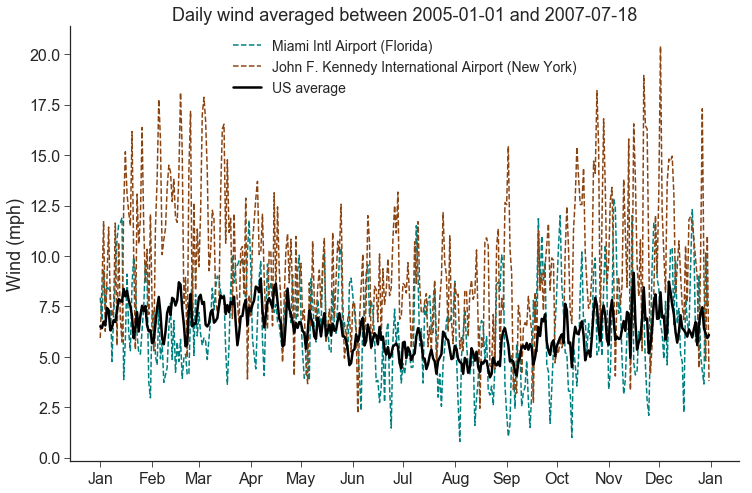

In [60]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

sns.set_style('ticks')

plt.plot(wind_miami.Date, wind_miami.MIA, '--', label = 'Miami Intl Airport (Florida)', color = 'teal');
plt.plot(wind_NY.Date, wind_NY.JFK, '--', label = 'John F. Kennedy International Airport (New York)', color = 'saddlebrown');
plt.plot(wind_US.Date, wind_US.Average, 'k-', label = 'US average', linewidth = 2.5);

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))

plt.ylabel('Wind (mph)',fontsize=18)
plt.tick_params(labelsize=16)

plt.legend(fontsize=14, loc=9)
plt.title('Daily wind averaged between 2005-01-01 and 2007-07-18', fontsize = 18)

sns.despine()

* Both Miami and New York have similar trends in wind daily averages to the US average
* New York has stronger winds than Miami and the US average

##### Weather US average

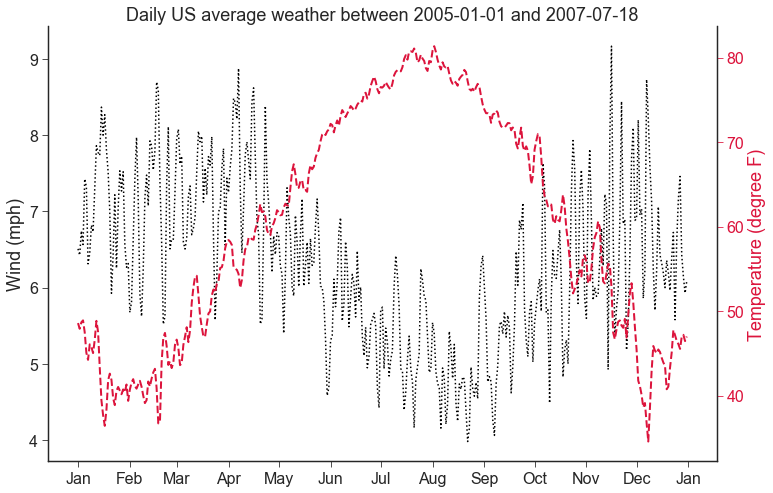

In [61]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.gca()

sns.set_style('ticks')

# plot wind
x = wind_US.Date
y1 = wind_US.Average

ax1.plot(x, y1, 'k:')
ax1.set_ylabel('Wind (mph)',fontsize=18)

#plot temperature
ax2 = ax1.twinx()
y2 = temperature_US.Average
ax2.plot(x, y2, '--', color = 'crimson', linewidth = 2)
ax2.set_ylabel('Temperature (degree F)', color='crimson', fontsize=18)
ax2.tick_params('y', colors='crimson')

ax1.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

plt.title('Daily US average weather between 2005-01-01 and 2007-07-18', fontsize = 18)

sns.despine(right = False)

* The US average wind data have more daily variability than the temperature data
* The trends are reversed, with lower winds when the temperature increases 

### Machine learning predictions

A possible application for these datasets would be to train a model to predict whether a flight will be delayed on arrival before its departure.   
* The target feature for the model would therefore be the `Arrival_delay` in the `flights` database
* Other features that could be considered would relate to the weather at arrival and destination, the airline, the airports of departure and arrival and the distance covered by the flight

#### Prepare data
Let's create a database with the needed information for each flight


In [62]:
flightsML = flights[['Date','Airline','Departure_Airport',
                      'Arrival_airport','Departure_schedule','Arrival_schedule',
                      'Departure_delay','Arrival_delay','Year','Month','Day']].copy()
flightsML.columns = ['Date','Airline','Departure_Airport',
                      'Arrival_Airport','Departure_Schedule','Arrival_Schedule',
                      'Departure_Delay','Arrival_Delay','Year','Month','Day']

# remove flights for all rows corresponding to Feb 29th as no weahter information is available
flightsML = flightsML[~((flightsML.Month == 2) & (flightsML.Day == 29))]

# remove flights to/from airports {'COU', 'EGE', 'OTH'} as no weahter information is available
flightsML = flightsML[~((flightsML.Arrival_Airport == 'COU') |
                        (flightsML.Departure_Airport == 'COU') |
                        (flightsML.Arrival_Airport == 'EGE') |
                        (flightsML.Departure_Airport == 'EGE') |
                        (flightsML.Arrival_Airport == 'OTH') |
                        (flightsML.Departure_Airport == 'OTH'))]

In [63]:
# flatten the pivot tables for weather phenomena

snow_flat = pd.DataFrame(snow.to_records()).copy()
snow_flat.columns = [hdr.replace("('Snow', '", "").replace("')", "") for hdr in snow_flat.columns]

temperature_flat = pd.DataFrame(temperature.to_records()).copy()
temperature_flat.columns = [hdr.replace("('Temperature', '", "").replace("')", "") for hdr in temperature_flat.columns]

wind_flat = pd.DataFrame(wind.to_records()).copy()
wind_flat.columns = [hdr.replace("('Wind', '", "").replace("')", "") for hdr in wind_flat.columns]

Add columns for average weather phenomena at the departure and arrival airport depending on day and month of the flight (daily averages)

In [64]:
flightsML['Snow_Departure'] = flightsML.apply(lambda row: snow_flat.loc[(snow_flat.Day == row.Day) & (snow_flat.Month == row.Month)][row.Departure_Airport].item(), axis=1)
flightsML['Snow_Arrival'] = flightsML.apply(lambda row: snow_flat.loc[(snow_flat.Day == row.Day) & (snow_flat.Month == row.Month)][row.Arrival_Airport].item(), axis=1)
flightsML['Temperature_Departure'] = flightsML.apply(lambda row: temperature_flat.loc[(temperature_flat.Day == row.Day) & (temperature_flat.Month == row.Month)][row.Departure_Airport].item(), axis=1)
flightsML['Temperature_Arrival'] = flightsML.apply(lambda row: temperature_flat.loc[(temperature_flat.Day == row.Day) & (temperature_flat.Month == row.Month)][row.Arrival_Airport].item(), axis=1)
flightsML['Wind_Departure'] = flightsML.apply(lambda row: wind_flat.loc[(wind_flat.Day == row.Day) & (wind_flat.Month == row.Month)][row.Departure_Airport].item(), axis=1)
flightsML['Wind_Arrival'] = flightsML.apply(lambda row: wind_flat.loc[(wind_flat.Day == row.Day) & (wind_flat.Month == row.Month)][row.Arrival_Airport].item(), axis=1)

Add information on the departure/arrival coordinates to compute distance covered by the flight

In [65]:
flightsML_coord = pd.merge(flightsML, airport_coord, left_on='Departure_Airport', right_on = 'Airport', how = 'left')
flightsML_coord = pd.merge(flightsML_coord, airport_coord, left_on='Arrival_Airport', right_on = 'Airport', how = 'left')

flightsML_coord['Distance'] = np.sqrt((flightsML_coord.Latitude_x-flightsML_coord.Latitude_y)**2 +
                                  (flightsML_coord.Longitude_x-flightsML_coord.Longitude_y)**2)

In [66]:
flightsML_coord.head()

,Date,Airline,Departure_Airport,Arrival_Airport,Departure_Schedule,Arrival_Schedule,Departure_Delay,Arrival_Delay,Year,Month,...,Temperature_Arrival,Wind_Departure,Wind_Arrival,Airport_x,Longitude_x,Latitude_x,Airport_y,Longitude_y,Latitude_y,Distance
0,2003-04-05,EV,MOB,SHV,18:30:00,20:18:00,-10,30,2003,4,...,65.666667,8.033333,9.266667,MOB,-88.24,30.69,SHV,-93.82,32.44,5.847983
1,2006-04-10,YV,MGM,CLT,16:23:00,18:42:00,-10,-9,2006,4,...,52.000000,5.566667,1.900000,MGM,-86.39,32.30,CLT,-80.94,35.21,6.178236
2,2006-04-05,YV,MGM,CLT,16:23:00,18:42:00,-8,-17,2006,4,...,57.666667,4.233333,6.500000,MGM,-86.39,32.30,CLT,-80.94,35.21,6.178236
3,2006-01-12,YV,MGM,CLT,16:23:00,18:39:00,-3,1,2006,1,...,54.333333,4.433333,2.566667,MGM,-86.39,32.30,CLT,-80.94,35.21,6.178236
4,2006-01-05,YV,MGM,CLT,16:14:00,18:30:00,0,10,2006,1,...,59.000000,6.133333,5.300000,MGM,-86.39,32.30,CLT,-80.94,35.21,6.178236


The obtained database `flightsML_coord` has the following columns for each flight:
* `Date`
* `Airline`
* `Departure_Airport`
* `Arrival_Airport`
* `Departure_Schedule`
* `Arrival_Schedule`
* `Departure_Delay`
* `Arrival_Delay`
* `Year`
* `Month`
* `Day`
* `Snow_Departure`
* `Snow_Arrival`
* `Temperature_Departure`
* `Temperature_Arrival`
* `Wind_Departure`
* `Wind_Arrival`
* `Airport_x`
* `Longitude_x`
* `Latitude_x`
* `Airport_y`
* `Longitude_y`
* `Latitude_y`
* `Distance`

#### Data preprocessing
* The following `features` will be considered:   
    + `Airline`
    + `Departure_Airport`
    + `Arrival_Airport`
    + `Departure_Delay`
    + `Snow_Departure`
    + `Snow_Arrival`
    + `Temperature_Departure`
    + `Temperature_Arrival`
    + `Wind_Departure`
    + `Wind_Arrival`
    + `Distance`
    + `Year`
    + `Month`
    + `Day`

In [67]:
features = ['Airline', 'Departure_Airport', 'Arrival_Airport','Departure_Delay',
            'Snow_Departure', 'Snow_Arrival', 'Temperature_Departure', 'Temperature_Arrival',
            'Wind_Departure', 'Wind_Arrival', 'Distance', 'Year', 'Month', 'Day']
x = flightsML_coord.loc[:, features]

* Convert categorical features

In [68]:
for categorical_feature in ['Airline','Departure_Airport', 'Arrival_Airport']:
    x[categorical_feature] = x[categorical_feature].astype('category')
    x[categorical_feature] = x[categorical_feature].cat.codes

* Scale features by removing the mean and scaling to unit variance

In [69]:
x = StandardScaler().fit_transform(x)

* The target to predict the delay is `Arrival_delay`, which should be separated from the database in order to train the model 
* If a flight arrival was delayed the target would be 1, if not 0 (target becomes binary)
* The delay is defined as the flight being 1 or more minutes behind schedule

In [70]:
y = flightsML_coord.loc[:,['Arrival_Delay']]

In [71]:
y['Arrival_Delay'] = np.where(y['Arrival_Delay']>0, 1, 0)
y = y.values

* Check if the target is reasonabily balanced

In [72]:
unique_elements, counts_elements = np.unique(y, return_counts=True)
print('There are {} flights on time and {} flights delayed'.format(counts_elements[0], counts_elements[1]))

There are 58658 flights on time and 41109 flights delayed


#### Train-Test split
Split the database in train and test subsets in order to verify the trained model performance

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y.ravel(), random_state = 42)

#### Prediction model

* An accuracy score of ~78% was achieved on the test dataset with a Random Forest Classifier with 50 estimators

In [74]:
forest = RandomForestClassifier(n_estimators = 50)
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)

print('Test accuracy: %.3f' % (accuracy_score(y_test, y_pred_forest)))

Test accuracy: 0.782


* The model generalises well as the cross validation score is close to the model score

In [75]:
kfold = model_selection.KFold(n_splits=10, random_state=42)
modelCV = RandomForestClassifier(n_estimators = 50)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv = kfold, scoring = scoring)
print('Average accuracy on 10-fold cross validation: %.3f' % (results.mean()))

Average accuracy on 10-fold cross validation: 0.774


* The confusion matrix returns the following:
    + True positive: 13212 flights delayed predicted as delayed
    + False positive: 1353 flights on time predicted as delayed
    + False negative: 4073 flights delayed predicted on time
    + True negative: 6304 flights on time predicted on time

In [76]:
confusion = confusion_matrix(y_test, y_pred_forest)
print(confusion)

[[13212  1353]
 [ 4073  6304]]


#### Possible improvements to the prediction model
* Parameter optimisation for a different scoring matrix: we might want to optimise the model to reduce the false positive or the false negatives instead of the general accuracy
* The weather data was used in terms of daily averages, better prediction could be achieved with information on weather on the day of the flight
* The flights for the 29th Feb and for the 3 airports for which the weather was not available were drop from the database. A better solution could have been to consider weather information for similar dates and close locations
* More models could have been tested in order to verify which algorithm would perform best in this situation
* More feature augmentation could have been performed to achieve better predictions
* The delay was defined as one or more minute behind schedule for arrival: ranges of delay could have been a better option (i.e. 10 minutes of delay is worse than 2 hours). Moreover, a threshold on minimum delay could have been set (i.e. flights with less then 10 minutes delay could have been considered on time)